In [4]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as t
from scipy.stats import mode
def tinvlogit(x):
    return t.exp(x) / (1 + t.exp(x))

df=pd.read_csv('/Users/arrigal001/Desktop/thads2013n.txt',sep=',') 
df=df[df['BURDEN']>0] 
df=df[df['AGE1']>0] 
df['OWN']=[1 if obj=='2' else 0 for obj in df['OWNRENT']]

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
with pm.Model() as model: 
    # Define priors
    intercept = pm.Normal('Intercept', 0, sd=10)
    x_coeff = pm.Normal('x', 0, sd=10)
    price_coef = pm.Normal('price', 0, sd=10)
    
    # Define likelihood
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(intercept+x_coeff*df['BEDRMS']+price_coef*df['COSTMED']),
                              observed=df['OWN'])
    WTP=pm.Deterministic('WTP',-x_coeff/price_coef)

    # Inference!
#     trace = pm.sample(3000)
    advi = pm.ADVI()
    approx = advi.fit(20000)
    
# pm.traceplot(trace)

Average Loss = 2.5601e+06: 100%|██████████| 20000/20000 [00:30<00:00, 648.07it/s]
Finished [100%]: Average Loss = 2.5601e+06


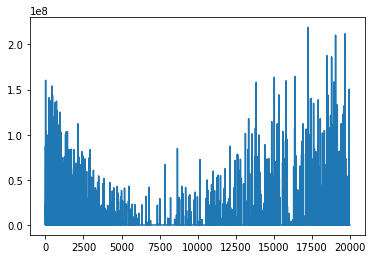

In [11]:
plt.plot(approx.hist)

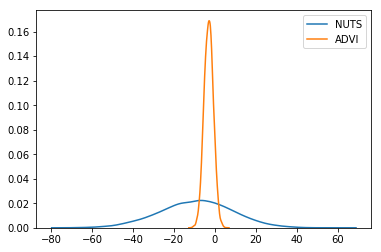

In [43]:
import seaborn as sns
ax = sns.kdeplot(trace['Intercept'], label='NUTS');
sns.kdeplot(approx.sample(10000)['Intercept'], label='ADVI');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a2183c8>,
      dtype=object)

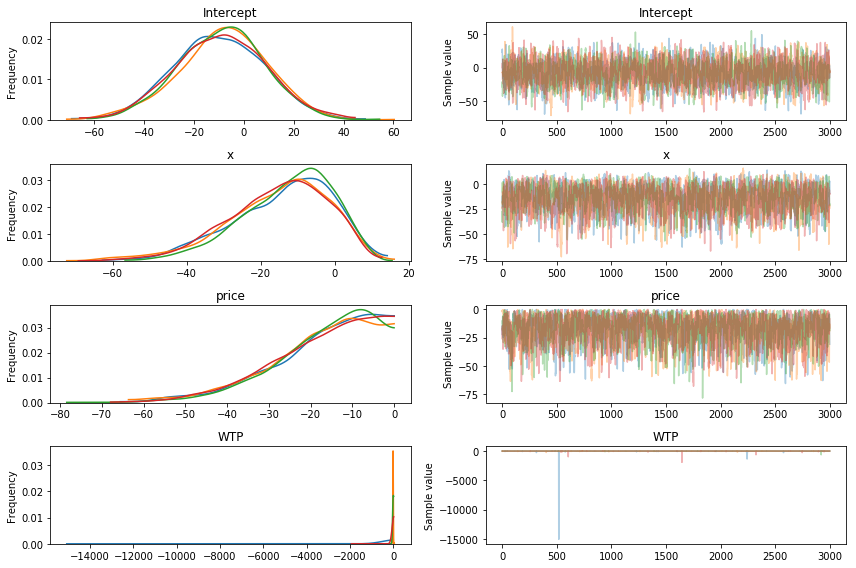

In [15]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b26a710>,
      dtype=object)

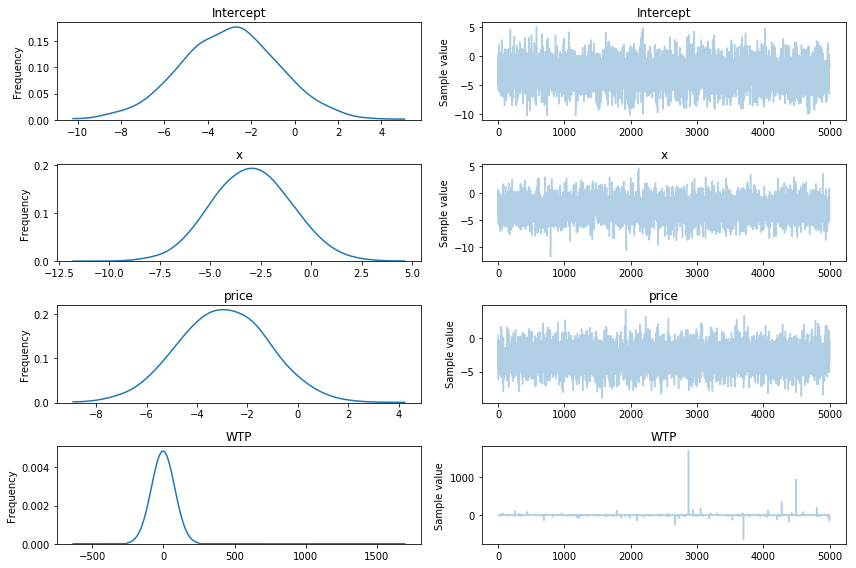

In [41]:
trace_advi = approx.sample(draws=5000)
pm.traceplot(trace_advi)

In [8]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

def logistic(x, b, noise=None):
    L = x.T.dot(b)
    if noise is not None:
        L = L+noise
    return 1/(1+np.exp(-L))

x1 = np.linspace(-10., 10, 10000)
x2 = np.linspace(0., 20, 10000)
bias = np.ones(len(x1))
X = np.vstack([x1,x2,bias]) # Add intercept
B =  [-10., 2., 1.] # Sigmoid params for X + intercept

# Noisy mean
pnoisy = logistic(X, B, noise=np.random.normal(loc=0., scale=0., size=len(x1)))
# dichotomize pnoisy -- sample 0/1 with probability pnoisy
# y = np.random.binomial(1., pnoisy)
y = [1 if x > 0.5 else 0 for x in pnoisy]

In [11]:
with pm.Model() as model: 
    # Define priors
    intercept = pm.Normal('Intercept', 0, sd=10)
    x1_coef = pm.Normal('x1', 0, sd=10)
    x2_coef = pm.Normal('x2', 0, sd=10)
    
    # Define likelihood
    likelihood = pm.Bernoulli('y', 
                              pm.math.sigmoid(intercept+x1_coef*X[0]+x2_coef*X[1]),
                              observed=y)

#     trace = pm.sample(3000)
#     advi = pm.ADVI()
#     approx = advi.fit(150000)
    approx = pm.fit(90000, method='advi')

Average Loss = 114.41: 100%|██████████| 90000/90000 [01:32<00:00, 968.97it/s] 
Finished [100%]: Average Loss = 114.4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c13bdc898>,
      dtype=object)

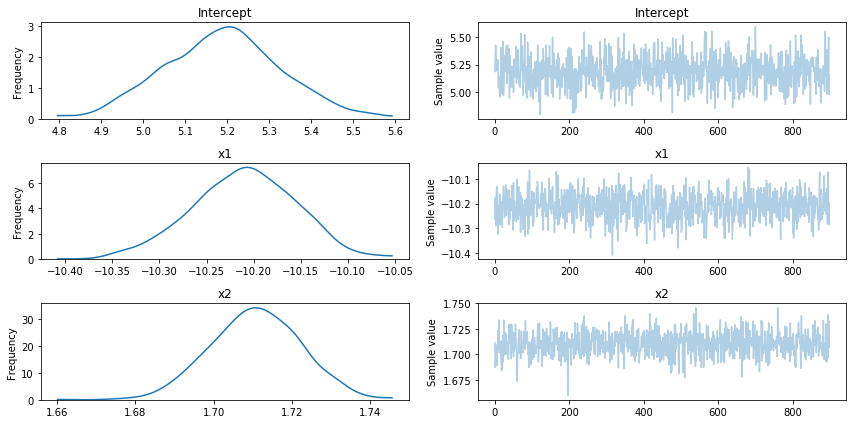

In [12]:
trace_advi = approx.sample(draws=900)
pm.traceplot(trace_advi)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24d423c8>,
      dtype=object)

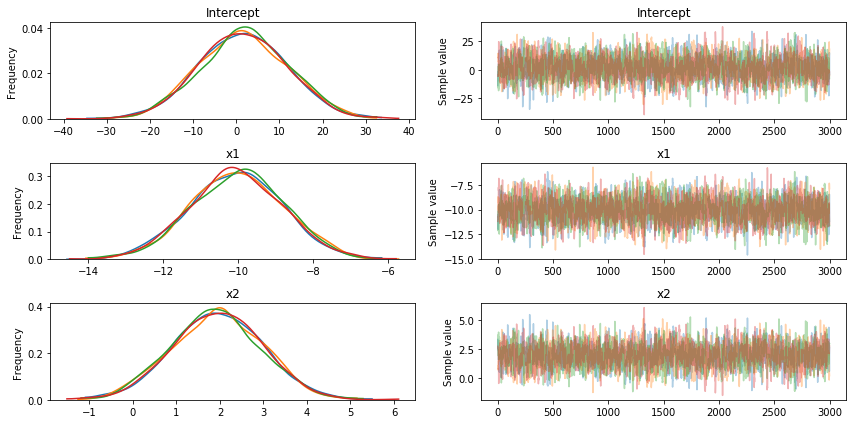

In [147]:
pm.traceplot(trace)

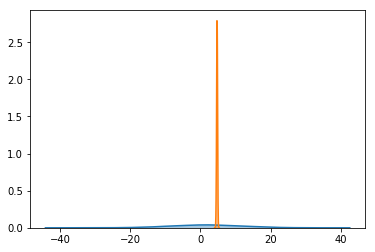

In [158]:
sns.distplot(trace['Intercept'])
sns.distplot(trace_advi['Intercept'])